<a href="https://colab.research.google.com/github/sneha-4515/IoT-Predictive-Maintenance-Engine/blob/main/IoT_Predictive_Maintenance_Engine_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🏭 FactoryGuard AI – Predictive Maintenance Engine
## Week 1 + Week 2

This notebook includes:

### ✅ Week 1 – Data Engineering
- Data Loading
- Dataset Merging
- Missing Value Handling
- Feature Engineering (Lag + Rolling)
- Target Creation (Failure in Next 24 Hours)
- Data Leakage Check

### ✅ Week 2 – Modeling & Hyperparameter Tuning
- Train Test Split
- Class Imbalance Handling (SMOTE)
- Logistic Regreesion
- Random Forest
- XGBoost
- RandomizedSearchCV
- Evaluation (F1 & Recall Focus)


Import Libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")


Loading Dataset

In [25]:
!gdown 1EEbHCVVvjBRl0MNn7c7mOCoQ6LGINqR9
! gdown 1EhOAKgE39ZPfySWR5ZxokI1TxOFOwlcV
! gdown 13_u-MMHacev2MD2bFcxzJQ4CkNyd9ktA

Downloading...
From: https://drive.google.com/uc?id=1EEbHCVVvjBRl0MNn7c7mOCoQ6LGINqR9
To: /content/PdM_telemetry.csv
100% 80.1M/80.1M [00:00<00:00, 127MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EhOAKgE39ZPfySWR5ZxokI1TxOFOwlcV
To: /content/PdM_failures.csv
100% 24.3k/24.3k [00:00<00:00, 50.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=13_u-MMHacev2MD2bFcxzJQ4CkNyd9ktA
To: /content/PdM_machines.csv
100% 1.58k/1.58k [00:00<00:00, 5.91MB/s]


In [26]:
telemetry = pd.read_csv("PdM_telemetry.csv", parse_dates=["datetime"])
failures = pd.read_csv("PdM_failures.csv", parse_dates=["datetime"])
machines = pd.read_csv("PdM_machines.csv")

print("Telemetry Shape:", telemetry.shape)
print("Failures Shape:", failures.shape)
print("Failures Shape:", machines.shape)


Telemetry Shape: (876100, 6)
Failures Shape: (761, 3)
Failures Shape: (100, 3)


Merging Dataset

In [27]:
telemetry = telemetry.merge(machines, on="machineID", how="left")
telemetry = telemetry.sort_values(["machineID", "datetime"])

telemetry.head()


,datetime,machineID,volt,rotate,pressure,vibration,model,age
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,model3,18
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,model3,18
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,model3,18


In [28]:
telemetry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   datetime   876100 non-null  datetime64[ns]
 1   machineID  876100 non-null  int64         
 2   volt       876100 non-null  float64       
 3   rotate     876100 non-null  float64       
 4   pressure   876100 non-null  float64       
 5   vibration  876100 non-null  float64       
 6   model      876100 non-null  object        
 7   age        876100 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 53.5+ MB


In [29]:
telemetry['model'].value_counts()

,count
model,
model3,306635
model4,280352
model2,148937
model1,140176


In [30]:
telemetry = pd.get_dummies(telemetry, drop_first=True)

In [31]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration,age,model_model2,model_model3,model_model4
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,False,True,False
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,18,False,True,False
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,18,False,True,False
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,18,False,True,False
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,18,False,True,False


In [32]:
telemetry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   datetime      876100 non-null  datetime64[ns]
 1   machineID     876100 non-null  int64         
 2   volt          876100 non-null  float64       
 3   rotate        876100 non-null  float64       
 4   pressure      876100 non-null  float64       
 5   vibration     876100 non-null  float64       
 6   age           876100 non-null  int64         
 7   model_model2  876100 non-null  bool          
 8   model_model3  876100 non-null  bool          
 9   model_model4  876100 non-null  bool          
dtypes: bool(3), datetime64[ns](1), float64(4), int64(2)
memory usage: 49.3 MB


CREATING TARGET (Failure in Next 24 Hours)

In [33]:
failures['failure_flag'] = 1

telemetry = telemetry.merge(
    failures[['machineID','datetime','failure_flag']],
    on=['machineID','datetime'],
    how='left'
)

telemetry['failure_flag'] = telemetry['failure_flag'].fillna(0)

telemetry['failure_next_24h'] = (
    telemetry.groupby('machineID')['failure_flag']
    .transform(lambda x: x.shift(-1).rolling(24).max())
)

telemetry['failure_next_24h'] = telemetry['failure_next_24h'].fillna(0)


In [34]:
telemetry['failure_next_24h'].value_counts()

,count
failure_next_24h,
0.0,858916
1.0,17226


Feture Engineering

In [35]:
sensor_cols = ['volt','rotate','pressure','vibration']

for col in sensor_cols:
    telemetry[f'{col}_lag1'] = telemetry.groupby('machineID')[col].shift(1)
    telemetry[f'{col}_lag2'] = telemetry.groupby('machineID')[col].shift(2)

for col in sensor_cols:
    telemetry[f'{col}_roll4'] = (
        telemetry.groupby('machineID')[col]
        .rolling(4)
        .mean()
        .reset_index(0,drop=True)
    )

telemetry = telemetry.dropna()


In [36]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration,age,model_model2,model_model3,model_model4,...,rotate_lag1,rotate_lag2,pressure_lag1,pressure_lag2,vibration_lag1,vibration_lag2,volt_roll4,rotate_roll4,pressure_roll4,vibration_roll4
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,18,False,True,False,...,527.349825,402.747490,75.237905,95.460525,34.178847,43.413973,168.137453,423.687682,98.256232,40.950662
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,18,False,True,False,...,346.149335,527.349825,109.248561,75.237905,41.122144,34.178847,163.485495,427.905881,97.958410,36.176369
5,2015-01-01 11:00:00,1,172.504839,430.323362,95.927042,35.655017,18,False,True,False,...,435.376873,346.149335,111.886648,109.248561,25.990511,41.122144,165.891899,434.799849,98.075039,34.236630
6,2015-01-01 12:00:00,1,156.556031,499.071623,111.755684,42.753920,18,False,True,False,...,430.323362,435.376873,95.927042,111.886648,35.655017,25.990511,162.283431,427.730298,107.204484,36.380398
7,2015-01-01 13:00:00,1,172.522781,409.624717,101.001083,35.482009,18,False,True,False,...,499.071623,430.323362,111.755684,95.927042,42.753920,35.655017,164.798418,443.599144,105.142614,34.970364


In [37]:
telemetry.info()

<class 'pandas.core.frame.DataFrame'>
Index: 875842 entries, 3 to 876141
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   datetime          875842 non-null  datetime64[ns]
 1   machineID         875842 non-null  int64         
 2   volt              875842 non-null  float64       
 3   rotate            875842 non-null  float64       
 4   pressure          875842 non-null  float64       
 5   vibration         875842 non-null  float64       
 6   age               875842 non-null  int64         
 7   model_model2      875842 non-null  bool          
 8   model_model3      875842 non-null  bool          
 9   model_model4      875842 non-null  bool          
 10  failure_flag      875842 non-null  float64       
 11  failure_next_24h  875842 non-null  float64       
 12  volt_lag1         875842 non-null  float64       
 13  volt_lag2         875842 non-null  float64       
 14  rotate_la

Train_Test Split

In [38]:
X = telemetry.drop(columns=['failure_next_24h','datetime','failure_flag'])
y = telemetry['failure_next_24h']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Handling Class Imbalance(SMOTE)

In [39]:
'''sm = SMOTE(
    sampling_strategy=0.3,  # only increase minority to 30% of majority
    random_state=42
)

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)'''


'sm = SMOTE(\n    sampling_strategy=0.3,  # only increase minority to 30% of majority\n    random_state=42\n)\n\nX_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)'

Logistic Regression Model(Base Model)

In [41]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    class_weight='balanced',
    max_iter=1000
)

lr.fit(X_train, y_train)

lr_preds = lr.predict(X_test)

print("Logistic F1:", f1_score(y_test, lr_preds))
print("Logistic Recall:", recall_score(y_test, lr_preds))
print(classification_report(y_test, lr_preds))

Logistic F1: 0.051938295750385326
Logistic Recall: 0.5820029027576198
              precision    recall  f1-score   support

         0.0       0.99      0.58      0.73    171724
         1.0       0.03      0.58      0.05      3445

    accuracy                           0.58    175169
   macro avg       0.51      0.58      0.39    175169
weighted avg       0.97      0.58      0.72    175169



Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, recall_score

rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=8,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)

print("Random Forest F1:", f1_score(y_test, rf_preds))
print("Random Forest Recall:", recall_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))


Random Forest F1: 0.054809521853996415
Random Forest Recall: 0.5811320754716981
              precision    recall  f1-score   support

         0.0       0.99      0.61      0.75    171724
         1.0       0.03      0.58      0.05      3445

    accuracy                           0.61    175169
   macro avg       0.51      0.59      0.40    175169
weighted avg       0.97      0.61      0.74    175169



In [43]:

# ================================
# 9️⃣ XGBOOST MODEL
# ================================

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

xgb.fit(X_train_sm, y_train_sm)

xgb_preds = xgb.predict(X_test)

print("XGBoost F1:", f1_score(y_test, xgb_preds))
print("XGBoost Recall:", recall_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))


XGBoost F1: 0.0
XGBoost Recall: 0.0
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    171724
         1.0       0.00      0.00      0.00      3445

    accuracy                           0.98    175169
   macro avg       0.49      0.50      0.50    175169
weighted avg       0.96      0.98      0.97    175169



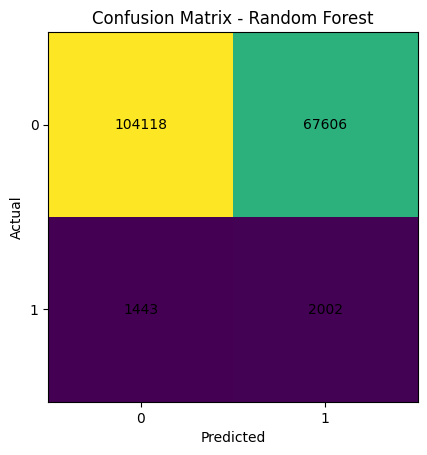

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, rf_preds)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xticks([0,1])
plt.yticks([0,1])
plt.show()

In [50]:

random_search = RandomizedSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    param_distributions={
        'max_depth': [4,6],
        'learning_rate': [0.05,0.1],
        'n_estimators': [100,150]
    },
    n_iter=4,
    cv=2,
    scoring='f1',
    random_state=42
)